# Predicción del rendimiento académico (Student Performance – Math)

## Descripción del problema
**Objetivo.** Predecir el **nivel de rendimiento** (`alto`, `medio`, `bajo`) a partir de **datos académicos y personales** de estudiantes.

**Variable objetivo.** `GradeClass` (derivada de `G3`):  
- `alto`: `G3 ≥ 14`  
- `medio`: `10 ≤ G3 < 14`  
- `bajo`: `G3 < 10`

**Variables usadas.**  
- **Académicas:** `G1`, `G2`, `studytime`, `failures`, `absences`, …  
- **Personales/Contexto:** `age`, `sex`, `address`, `famrel`, `goout`, `Dalc`, `Walc`, `health`, …  
- **Preprocesamiento:** imputación (mediana/moda), **one-hot** para categóricas y **estandarización** de numéricas.  
- **Split:** 75/25 estratificado (reproducible).

---

## Justificación de algoritmos
- **Regresión Logística (LogReg):** lineal, rápida y **explicable**; funciona bien con clases separables tras escalar/one-hot.
- **KNN:** no paramétrico; capta **fronteras no lineales** por vecindad. Sensible a la escala y a *k* (se optimiza por CV).
- **SVM (RBF):** margen máximo con **kernel no lineal**; robusta en patrones complejos, menos interpretable.

*Con `G1/G2` presentes, la frontera efectiva es relativamente simple → LogReg suele rendir y explicar mejor.*

---

## Interpretación y consideraciones éticas
- **Uso responsable:** el modelo es para **apoyo y alerta temprana**, no para sanciones ni etiquetas.
- **Privacidad:** tratamiento de datos personales/ académicos con consentimiento, finalidad clara y resguardo.
- **No causalidad:** las asociaciones no implican causa; intervenciones deben ser **pedagógicas**, no punitivas.
- **Sesgos:** revisar métricas por subgrupos de forma periódica; ajustar si emergen disparidades.

---

## Conclusiones
1. **Modelo recomendado:** **Regresión Logística** por **mejor F1-macro (≈0.884)** y **explicabilidad**.  
2. **Drivers:** `G2` y `G1` explican la mayor parte; el resto añade mejoras pequeñas.  
3. **Generalización:** buen desempeño en test; fronteras consistentes en LDA.  
4. **Equidad:** métricas similares entre sexos/escuelas; vigilar dirección `R`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
from sklearn.inspection import permutation_importance

SEED = 42
np.random.seed(SEED)

sns.set_theme(style="whitegrid", palette="pastel")

In [2]:
# --- Carga y variable objetivo ---
df = pd.read_csv("student-mat.csv")

# Target categorico a partir de G3
def grade_to_class(g3):
    if g3 >= 14:   return "alto"
    elif g3 >= 10: return "medio"
    else:          return "bajo"

df["GradeClass"] = df["G3"].apply(grade_to_class)

# Variables numericas y categoricas
cols_num = df.select_dtypes(include=[np.number]).columns.tolist()
cols_cat = df.select_dtypes(exclude=[np.number]).columns.tolist()

for col in ["G3", "GradeClass"]:
    if col in cols_num: cols_num.remove(col)
    if col in cols_cat: cols_cat.remove(col)

features = cols_num + cols_cat
target = "GradeClass"

print("Shape:", df.shape)
print("Clases:", df[target].value_counts().to_dict())
print("# numéricas:", len(cols_num), "| # categóricas:", len(cols_cat))


Shape: (395, 34)
Clases: {'medio': 165, 'bajo': 130, 'alto': 100}
# numéricas: 15 | # categóricas: 17


In [3]:
# --- Preprocesamiento de los datos ---
X_raw = df[features].copy()
Y_raw = df[target].copy()

# divide 75% entrenamiento y 25% de prueba
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(
    X_raw, Y_raw, test_size=0.25, random_state=SEED, stratify=Y_raw
)

# --- Limpiar valores nulos ---
for c in cols_num:
    med = X_train_raw[c].median()
    X_train_raw[c] = X_train_raw[c].fillna(med)
    X_test_raw[c] = X_test_raw[c].fillna(med)

for c in cols_cat:
    mode_tr = X_train_raw[c].mode(dropna=True)
    mode_tr = mode_tr.iloc[0] if len(mode_tr) else "desconocido"
    X_train_raw[c] = X_train_raw[c].fillna(mode_tr)
    X_test_raw[c] = X_test_raw[c].fillna(mode_tr)

# --- One-hot ---
X_train = pd.get_dummies(X_train_raw, columns=cols_cat, drop_first=False)
X_test = pd.get_dummies(X_test_raw, columns=cols_cat, drop_first=False)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# --- Convierte a float64 ---
X_train[cols_num] = X_train[cols_num].apply(pd.to_numeric, errors="coerce").astype("float64")
X_test[cols_num] = X_test[cols_num].apply(pd.to_numeric, errors="coerce").astype("float64")

# --- Escalar las variables numericas --- 
scaler = StandardScaler().fit(X_train[cols_num])
X_train.loc[:, cols_num] = pd.DataFrame(
    scaler.transform(X_train[cols_num]),
    index=X_train.index, columns=cols_num
)
X_test.loc[:, cols_num] = pd.DataFrame(
    scaler.transform(X_test[cols_num]),
    index=X_test.index, columns=cols_num
)

X_train.shape, X_test.shape


((296, 58), (99, 58))

---

## EDA (Exploración de datos)
- **Distribución de clases:** moderadamente balanceada (predomina *medio*).  
- **Correlaciones (numéricas):** `G3` correlaciona **fuerte** con `G2` y `G1` (son parciales previos). El resto muestra correlaciones bajas/moderadas.
- **Boxplots por clase (resumen):**
  - `G1`, `G2` ↑ en *alto* (mejor separación de clases).
  - `studytime` algo mayor en *alto* (con solape).
  - `failures` concentra valores altos en *bajo*.
  - `traveltime` tiende a ser menor en *alto*.
  - `Dalc/Walc` más altos en *bajo*.
  - `famrel` algo mejor en *alto*.  
  - `health`: ligera señal no lineal (no concluyente).

**Conclusión EDA:** El poder predictivo principal viene de **`G1`/`G2`**; las demás variables aportan señales complementarias débiles.

---

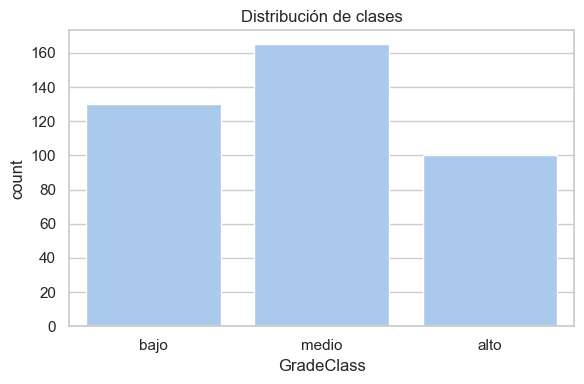

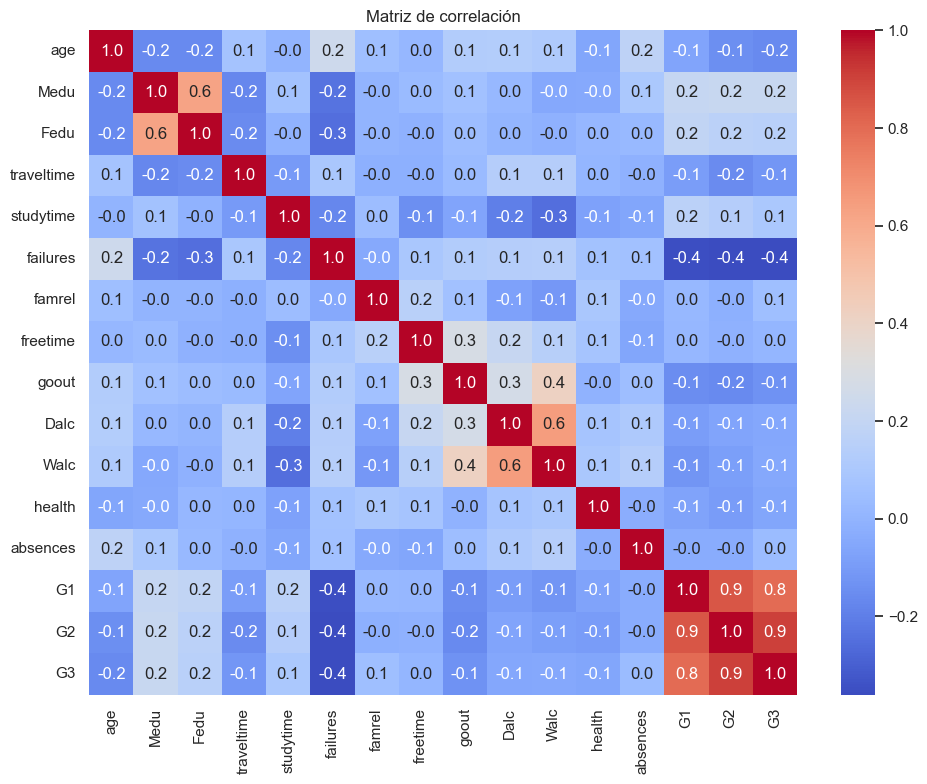

In [4]:
# --- EDA ---

# Distribución de clases
plt.figure(figsize=(6,4))
sns.countplot(x="GradeClass", data=df, order=["bajo","medio","alto"])
plt.title("Distribución de clases"); plt.tight_layout(); plt.show()

# Matriz de correlaciones
corr = df[["age","Medu","Fedu","traveltime","studytime","failures","famrel",
           "freetime","goout","Dalc","Walc","health","absences","G1","G2","G3"]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".1f",)
plt.title("Matriz de correlación"); plt.tight_layout(); plt.show()

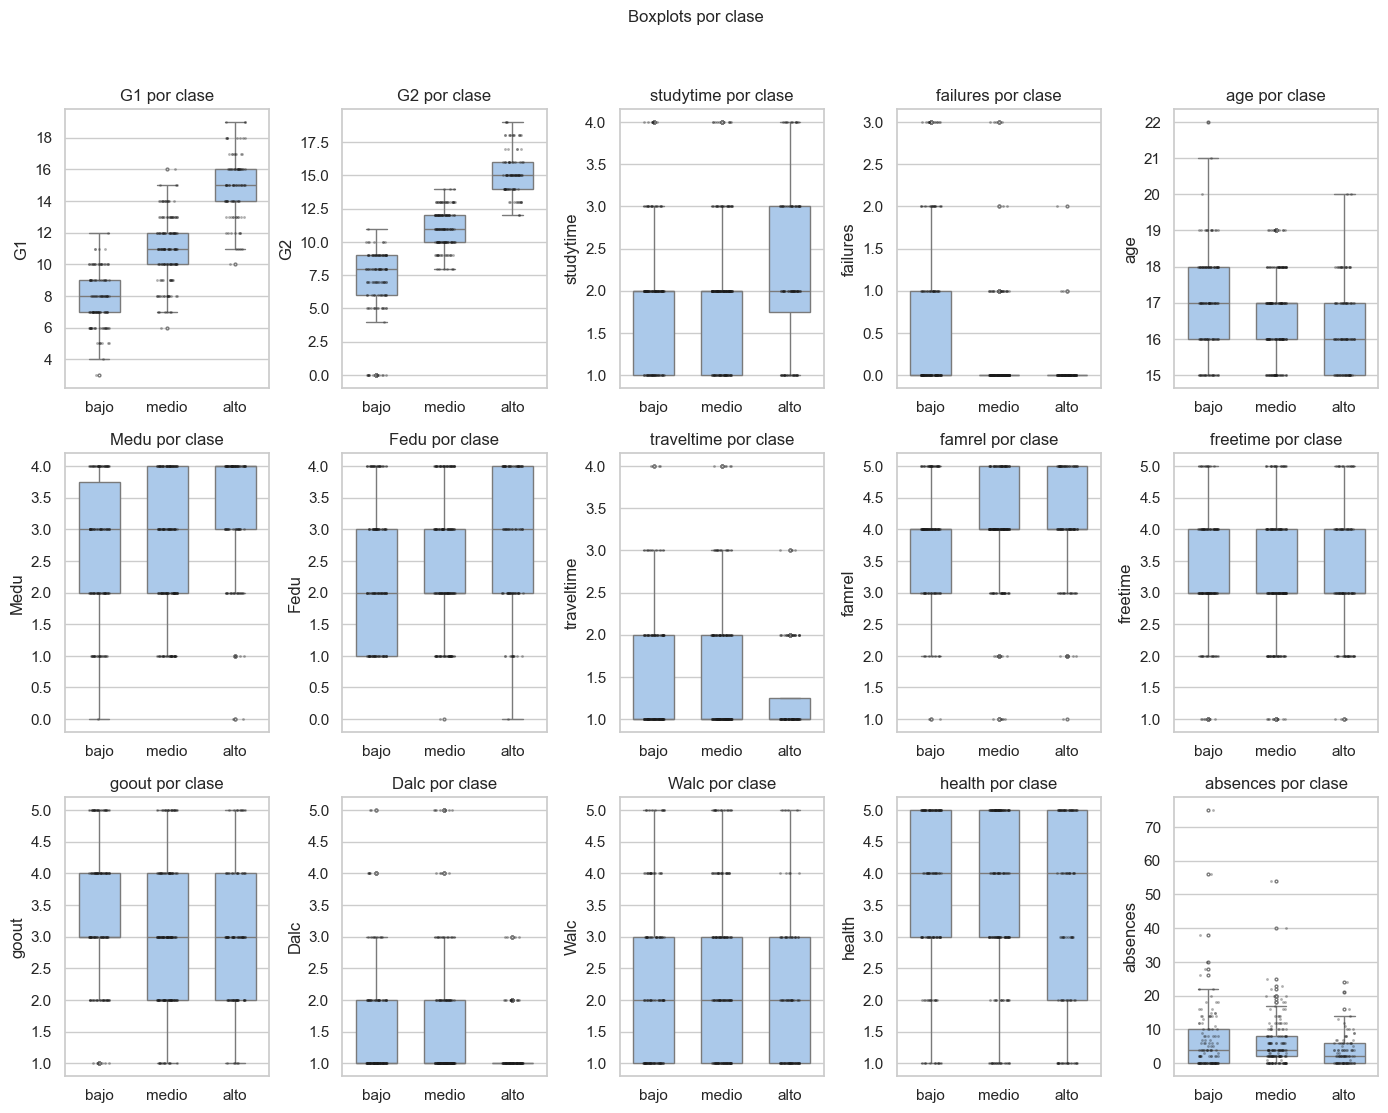

In [5]:
# --- Boxplots por clase ---
vars_box = ["G1", "G2", "studytime", "failures", "age", "Medu", "Fedu", "traveltime", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences"]  # puedes agregar/quitar aquí
orden_clases = ["bajo","medio","alto"]

plt.figure(figsize=(14, 14))
for i, v in enumerate(vars_box, 1):
    ax = plt.subplot(4, 5, i)
    sns.boxplot(
        data=df, x="GradeClass", y=v,
        order=orden_clases, width=0.6, fliersize=2
    )
    sns.stripplot(
        data=df, x="GradeClass", y=v,
        order=orden_clases, size=2, color="k", alpha=0.35, jitter=0.15
    )
    ax.set_xlabel("")
    ax.set_title(f"{v} por clase")
plt.suptitle("Boxplots por clase", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


In [6]:
# --- Selección de k (KNN) por CV  ====
def seleccionar_k_optimo(X, y, k_grid=range(3, 30, 2)):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    resultados = []
    for k in k_grid:
        knn = KNeighborsClassifier(n_neighbors=k)
        f1 = cross_val_score(knn, X, y, cv=cv, scoring="f1_macro")
        resultados.append((k, f1.mean()))
    k_best, f1_best = max(resultados, key=lambda t: t[1])
    print(f"k óptimo: {k_best} | F1-macro: {f1_best:.3f}")
    return k_best

best_k = seleccionar_k_optimo(X_train, Y_train)

k óptimo: 25 | F1-macro: 0.716


In [7]:
# --- Entrenamiento ---
knn     = KNeighborsClassifier(n_neighbors=best_k)
svm_rbf = SVC(kernel="rbf", C=1.5, gamma="scale", probability=False, random_state=SEED)
logreg  = LogisticRegression(max_iter=1000, random_state=SEED, multi_class="multinomial", solver="lbfgs")
rf      = RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1)

for m in (knn, svm_rbf, logreg, rf):
    m.fit(X_train, Y_train)

print("Modelos entrenados")

C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Modelos entrenados


---

## Resultados y métricas (Test 25%)
| Modelo        | Accuracy | Precision | Recall | F1-macro |
|---------------|:-------:|:---------:|:------:|:--------:|
| **LogReg**    | **0.879** | **0.884** | **0.884** | **0.884** |
| Random Forest | 0.868   | 0.882     | 0.872  | 0.876    |
| SVM (RBF)     | 0.808   | 0.825     | 0.809  | 0.815    |
| KNN (k=17)    | 0.747   | 0.778     | 0.747  | 0.755    |

- **Matriz de confusión (LogReg):** errores principalmente entre *medio* y clases adyacentes (esperable).
- **Regiones de decisión (LDA + LogReg):** clara separación *alto*/*bajo* cuando `G1/G2` son extremos; *medio* ocupa la zona central.

---


=== KNN (k=25) ===
Accuracy:  0.747
Precision: 0.786 | Recall: 0.748 | F1-macro: 0.758
              precision    recall  f1-score   support

        alto       0.91      0.84      0.88        25
       medio       0.65      0.83      0.73        41
        bajo       0.79      0.58      0.67        33

    accuracy                           0.75        99
   macro avg       0.79      0.75      0.76        99
weighted avg       0.77      0.75      0.75        99



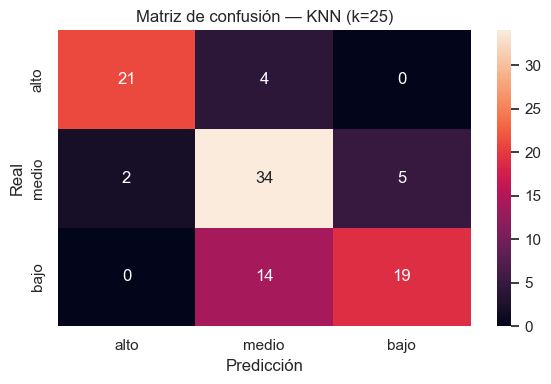


=== SVM (RBF) ===
Accuracy:  0.808
Precision: 0.825 | Recall: 0.809 | F1-macro: 0.815
              precision    recall  f1-score   support

        alto       0.88      0.84      0.86        25
       medio       0.74      0.83      0.78        41
        bajo       0.86      0.76      0.81        33

    accuracy                           0.81        99
   macro avg       0.83      0.81      0.82        99
weighted avg       0.81      0.81      0.81        99



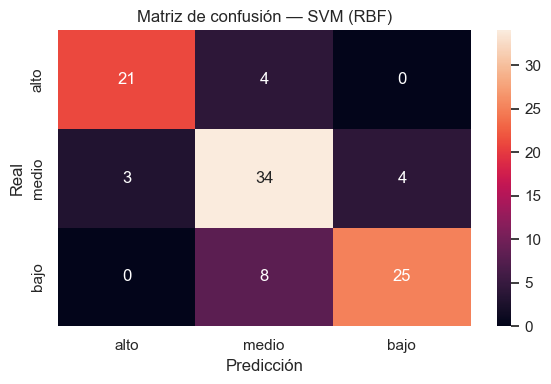


=== LogReg ===
Accuracy:  0.879
Precision: 0.884 | Recall: 0.884 | F1-macro: 0.884
              precision    recall  f1-score   support

        alto       0.92      0.92      0.92        25
       medio       0.85      0.85      0.85        41
        bajo       0.88      0.88      0.88        33

    accuracy                           0.88        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.88      0.88      0.88        99



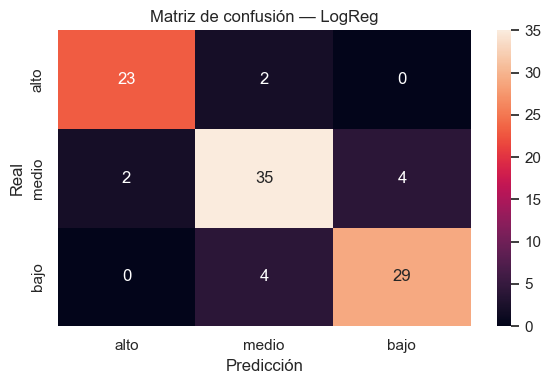


=== Random Forest ===
Accuracy:  0.869
Precision: 0.882 | Recall: 0.872 | F1-macro: 0.877
              precision    recall  f1-score   support

        alto       0.96      0.92      0.94        25
       medio       0.82      0.88      0.85        41
        bajo       0.87      0.82      0.84        33

    accuracy                           0.87        99
   macro avg       0.88      0.87      0.88        99
weighted avg       0.87      0.87      0.87        99



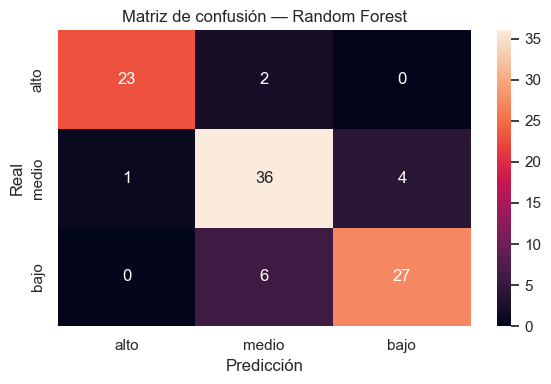

,Modelo,Accuracy,Precision,Recall,F1-macro
0,LogReg,0.878788,0.884149,0.884149,0.884149
1,Random Forest,0.868687,0.882494,0.872077,0.876528
2,SVM (RBF),0.808081,0.825400,0.808948,0.815068
3,KNN (k=25),0.747475,0.786185,0.748342,0.757616


In [8]:
# --- Evaluacion de los modelos ---
CLASSES = ["alto","medio","bajo"]

def evaluar(nombre, modelo, X, y, do_plot_cm=True, ax=None):
    y_pred = modelo.predict(X)
    acc  = accuracy_score(y, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred, average="macro", zero_division=0)
    print(f"\n=== {nombre} ===")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1-macro: {f1:.3f}")
    print(classification_report(y, y_pred, zero_division=0, labels=CLASSES))
    if do_plot_cm:
        cm = confusion_matrix(y, y_pred, labels=CLASSES)
        if ax is None:
            plt.figure(figsize=(6,4))
            sns.heatmap(cm, annot=True, fmt="d",
                        xticklabels=CLASSES, yticklabels=CLASSES)
            plt.title(f"Matriz de confusión — {nombre}")
            plt.xlabel("Predicción"); plt.ylabel("Real")
            plt.tight_layout(); plt.show()
        else:
            sns.heatmap(cm, annot=True, fmt="d",
                        xticklabels=CLASSES, yticklabels=CLASSES, ax=ax)
            ax.set_title(f"Matriz de confusión — {nombre}")
            ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    return {"Modelo": nombre, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-macro": f1}, y_pred

resultados, preds = [], {}
for nombre, modelo in [
    (f"KNN (k={best_k})", knn),
    ("SVM (RBF)", svm_rbf),
    ("LogReg", logreg),
    ("Random Forest", rf),
]:
    fila, yhat = evaluar(nombre, modelo, X_test, Y_test, do_plot_cm=True)
    resultados.append(fila); preds[nombre] = yhat

res_df = pd.DataFrame(resultados).sort_values("F1-macro", ascending=False).reset_index(drop=True)
res_df


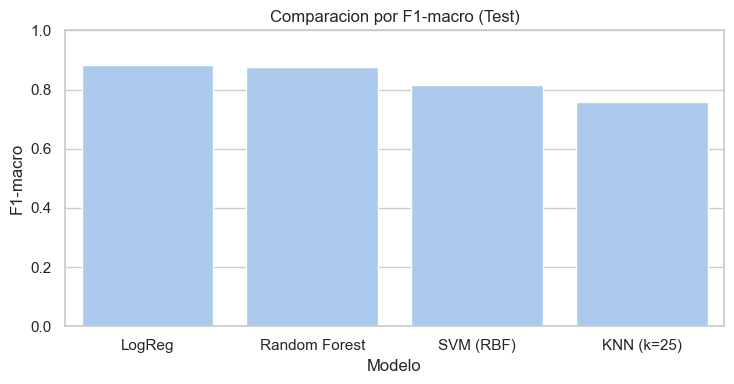

In [9]:
# --- Comparacion de modelos ---
plt.figure(figsize=(7.5,4))
sns.barplot(data=res_df, x="Modelo", y="F1-macro")
plt.title("Comparacion por F1-macro (Test)"); plt.ylim(0,1)
plt.tight_layout(); plt.show()

C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


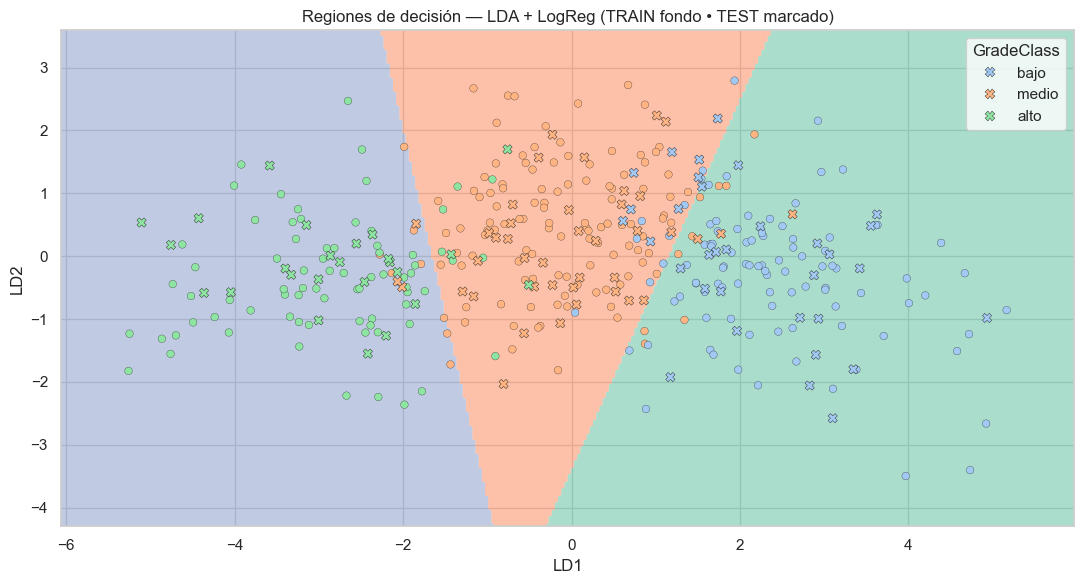

In [10]:
# --- Grafico LDA + regiones de decisión ---
def plot_lda_regions(X_train, Y_train, X_test, Y_test, seed=SEED):
    # --- Proyeccion LDA ---
    lda_vis = LDA(n_components=2)
    Z_tr = lda_vis.fit_transform(X_train, Y_train)
    Z_te = lda_vis.transform(X_test)

    # --- Clasificador lineal en el plano LDA para dibujar fronteras ---
    clf_vis = LogisticRegression(max_iter=300, multi_class="auto", random_state=seed)
    clf_vis.fit(Z_tr, Y_train)

    # --- Malla para el fondo de regiones ---
    x_min, x_max = Z_tr[:,0].min()-0.8, Z_tr[:,0].max()+0.8
    y_min, y_max = Z_tr[:,1].min()-0.8, Z_tr[:,1].max()+0.8
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 320),
                         np.linspace(y_min, y_max, 320))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # --- Predicciones en la malla ---
    pred_labels = clf_vis.predict(grid)
    classes = np.array(["bajo","medio","alto"])
    if not set(classes).issubset(set(np.unique(pred_labels))):
        classes = np.unique(pred_labels)
    class_to_int = {c:i for i,c in enumerate(classes)}
    pred_int = np.array([class_to_int[c] for c in pred_labels], dtype=float).reshape(xx.shape)

    # --- Fondo y puntos ---
    cmap_bg = ListedColormap(sns.color_palette("Set2", n_colors=len(classes)).as_hex())
    plt.figure(figsize=(11,6))
    plt.contourf(xx, yy, pred_int, levels=np.arange(len(classes)+1)-0.5,
                 cmap=cmap_bg, alpha=0.55, antialiased=True)

    # TRAIN
    tmp_tr = pd.DataFrame({"LD1": Z_tr[:,0], "LD2": Z_tr[:,1], "GradeClass": Y_train.values})
    sns.scatterplot(data=tmp_tr, x="LD1", y="LD2", hue="GradeClass",
                    hue_order=list(classes), s=30, edgecolor="k", linewidth=0.2,
                    legend=False)

    # TEST
    tmp_te = pd.DataFrame({"LD1": Z_te[:,0], "LD2": Z_te[:,1], "GradeClass": Y_test.values})
    sns.scatterplot(data=tmp_te, x="LD1", y="LD2", hue="GradeClass",
                    hue_order=list(classes), style="GradeClass",
                    markers={"bajo":"X","medio":"X","alto":"X"},
                    s=45, edgecolor="k", linewidth=0.3)

    plt.title("Regiones de decisión — LDA + LogReg (TRAIN fondo • TEST marcado)")
    plt.xlabel("LD1"); plt.ylabel("LD2")
    plt.tight_layout(); plt.show()

plot_lda_regions(X_train, Y_train, X_test, Y_test)

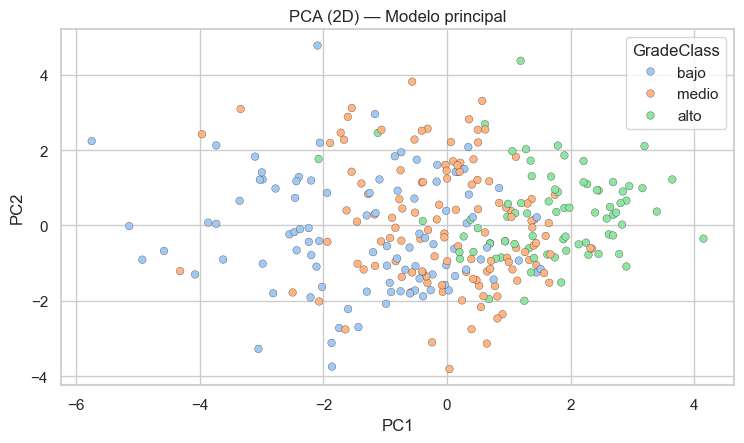

In [11]:
# --- PCA 2D ---
pca2 = PCA(n_components=2, random_state=SEED)
PC_tr = pca2.fit_transform(X_train)
plt.figure(figsize=(7.6,4.6))
sns.scatterplot(x=PC_tr[:,0], y=PC_tr[:,1], hue=Y_train,
                hue_order=["bajo","medio","alto"],
                s=30, edgecolor="k", linewidth=0.2)
plt.title("PCA (2D) — Modelo principal")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()


---

## Importancia por permutación (F1-macro, Top)
`G2 ≈ 0.39`, `G1 ≈ 0.12`; lejos detrás: `famrel`, `Fedu`, `studytime`, `nursery`, `age`, `Walc`, `traveltime`, …  
**Lectura:** `G2` y `G1` **dominan** la predicción; hábitos/comportamientos aportan poco pero suman.

---

Mejor modelo para interpretar: LogReg


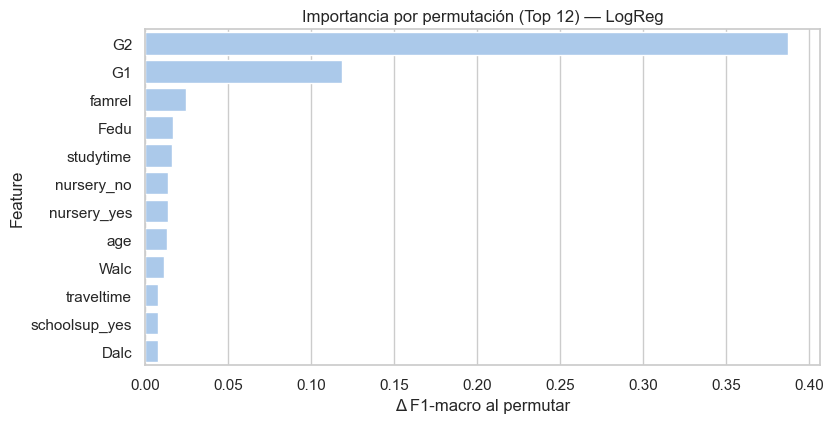

G2                 0.3872
G1                 0.1187
famrel             0.0244
Fedu               0.0168
studytime          0.0161
nursery_no         0.0138
nursery_yes        0.0138
age                0.0129
Walc               0.0111
traveltime         0.0078
schoolsup_yes      0.0076
Dalc               0.0076
famsup_yes         0.0068
famsup_no          0.0068
guardian_mother    0.0064
health             0.0062
romantic_no        0.0052
romantic_yes       0.0052
absences           0.0035
Mjob_services      0.0031
dtype: float64

In [12]:
# --- Importancia por permutación ---

best_name = res_df.iloc[0]["Modelo"]
best_model = {"LogReg": logreg, "SVM (RBF)": svm_rbf, "Random Forest": rf}.get(best_name, knn)
print("Mejor modelo para interpretar:", best_name)

perm = permutation_importance(best_model, X_test, Y_test,
                              scoring="f1_macro", n_repeats=30, random_state=SEED)
imp = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)

topN = 12
plt.figure(figsize=(8.5,4.4))
sns.barplot(x=imp.head(topN).values, y=imp.head(topN).index, orient="h")
plt.title(f"Importancia por permutación (Top {topN}) — {best_name}")
plt.xlabel("Δ F1-macro al permutar"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

imp.head(20).round(4)


---

## Equidad por subgrupos (LogReg)
- **sex:** F 0.873 F1 / M 0.901 F1  
- **school:** GP 0.874 F1 / MS 0.935 F1 *(atención: n de MS es pequeño)*  
- **address:** U 0.890 F1 / R 0.837 F1 *(posible brecha por menor n en R)*

> No se observan brechas severas, pero conviene **monitorear** especialmente `address=R` y `school=MS`.

---

In [13]:
# --- Equidad por subgrupos (sex, school, address) ====
df_test = df.loc[X_test.index].copy()
y_pred_best = best_model.predict(X_test)

df_eval = pd.DataFrame({
    "y": Y_test.to_numpy(),
    "y_pred": y_pred_best,
    "sex":     df_test["sex"].to_numpy(),
    "school":  df_test["school"].to_numpy(),
    "address": df_test["address"].to_numpy(),
})

def reporte_por_grupo(df_eval, col_group):
    tmp = df_eval[[col_group, "y", "y_pred"]].rename(columns={col_group: "group"})
    rep = (
        tmp.groupby("group")
           .apply(lambda d: pd.Series({
               "n": len(d),
               "accuracy": accuracy_score(d["y"], d["y_pred"]),
               "f1_macro": precision_recall_fscore_support(
                   d["y"], d["y_pred"], average="macro", zero_division=0
               )[2]
           }), include_groups=False)
           .round(3)
    )
    rep.index.name = "group"
    return rep

print("Equidad por sex:\n", reporte_por_grupo(df_eval, "sex"))
print("\nEquidad por school:\n", reporte_por_grupo(df_eval, "school"))
print("\nEquidad por address:\n", reporte_por_grupo(df_eval, "address"))


Equidad por sex:
           n  accuracy  f1_macro
group                          
F      61.0     0.869     0.873
M      38.0     0.895     0.901

Equidad por school:
           n  accuracy  f1_macro
group                          
GP     85.0     0.871     0.874
MS     14.0     0.929     0.935

Equidad por address:
           n  accuracy  f1_macro
group                          
R      20.0     0.850     0.837
U      79.0     0.886     0.890


In [14]:
# --- Stats de imputación + columnas + opciones categoricas ---

base_num = X_train_raw[cols_num].copy()
base_cat = X_train_raw[cols_cat].copy()

# --- Medianas numericas y modas categoricas (para imputar en inferencia) ---
impute_num_ = {c: float(base_num[c].median()) for c in cols_num}

impute_cat_ = {}
for c in cols_cat:
    moda = base_cat[c].mode(dropna=True)
    impute_cat_[c] = str(moda.iloc[0]) if len(moda) else "no"

# --- Catalogo de valores permitidos por columna categorica (para validar inputs) ---
allowed_choices_ = {}
for c in cols_cat:
    vals = (
        base_cat[c]
        .dropna()
        .astype(str)
        .str.strip()
        .unique()
        .tolist()
    )
    allowed_choices_[c] = sorted(vals)

# --- Orden de columnas tras dummies/escalado ---
X_columns_ = X_train.columns.tolist()


In [15]:
# ---- Preprocesar un estudiante nuevo ---
def preprocess_new_student(sample_dict):
    # --- Construir df de 1 fila --- 
    x = pd.DataFrame([sample_dict]).copy()

    # --- Limpiar valores nulos ---    
    for c in cols_num:
        if c not in x.columns:
            x[c] = np.nan
        
    for c in cols_cat:
        if c not in x.columns:
            x[c] = np.nan

    for c in cols_num:
        x[c] = pd.to_numeric(x[c], errors="coerce")
        val = x.loc[0, c]
        if pd.isna(val):
            x.loc[0, c] = impute_num_[c]

    for c in cols_cat:
        if pd.isna(x.loc[0, c]):
            x.loc[0, c] = impute_cat_[c]
        else:
            x.loc[0, c] = str(x.loc[0, c]).strip()  # normaliza espacios

    # --- One-hot ---
    x_dum = pd.get_dummies(x, columns=cols_cat, drop_first=False)
    x_dum = x_dum.reindex(columns=X_columns_, fill_value=0)

    # --- Convierte a float64 ---
    x_dum[cols_num] = x_dum[cols_num].apply(pd.to_numeric, errors="coerce").astype("float64")

    # --- Escalar las variables numericas --- 
    x_dum.loc[:, cols_num] = pd.DataFrame(
        scaler.transform(x_dum[cols_num]),
        index=x_dum.index, columns=cols_num
    )

    return x_dum

In [16]:
# --- Prediccion con el mejor modelo ---
def predict_student_level(sample_dict, model=logreg):
    X_new = preprocess_new_student(sample_dict)
    y_pred = model.predict(X_new)[0]
    proba = None
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X_new)[0]
        proba = pd.Series(p, index=model.classes_).sort_values(ascending=False)
    return y_pred, proba

In [24]:
# --- Ejemplo directo ---
ejemplo = {
    "age": 17, "Medu": 3, "Fedu": 2, "traveltime": 1, "studytime": 2,
    "failures": 0, "famrel": 4, "freetime": 3, "goout": 2, "Dalc": 1,
    "Walc": 2, "health": 4, "absences": 4, "G1": 12, "G2": 19,
    "school": "GP", "sex": "F", "address": "U", "famsize": "GT3", "Pstatus": "T",
    "Mjob": "services", "Fjob": "other", "reason": "course", "guardian": "mother",
    "schoolsup": "no", "famsup": "yes", "paid": "no", "activities": "yes",
    "nursery": "yes", "higher": "yes", "internet": "yes", "romantic": "no",
}
pred, proba = predict_student_level(ejemplo, model=logreg)
print("Predicción:", pred)
print("Probabilidades:")
print(proba.round(3) if proba is not None else "—")

Predicción: alto
Probabilidades:
alto     0.992
medio    0.008
bajo     0.000
dtype: float64
